# Hybrid Collaboritve and Content Based Neurel Network Recommender System 

In [20]:
import pandas as pd
import numpy as np

In [21]:
movies = pd.read_csv("../data/ml-latest-small/movies.csv")
movies['genres'] = movies['genres'].str.split('|')
print(movies.shape)
movies.head()

(9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [22]:
# Load the tags dataset
tags = pd.read_csv('../data/ml-latest/tags_filtered_120.csv')
print(tags.shape)
tags.head()

(555414, 4)


,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,260,sci-fi,1442169410
2,14,260,space action,1442169421
3,14,318,imdb top 250,1442615195
4,14,318,justice,1442615192


In [23]:
# Load the ratings dataset
ratings = pd.read_csv('../data/ml-latest-small/ratings.csv')
ratings = ratings.drop('timestamp',axis=1)
print(ratings.shape)
ratings.head()

(100836, 3)


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


## Exploratory Data Analysis

In [24]:
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
from wordcloud import WordCloud, STOPWORDS

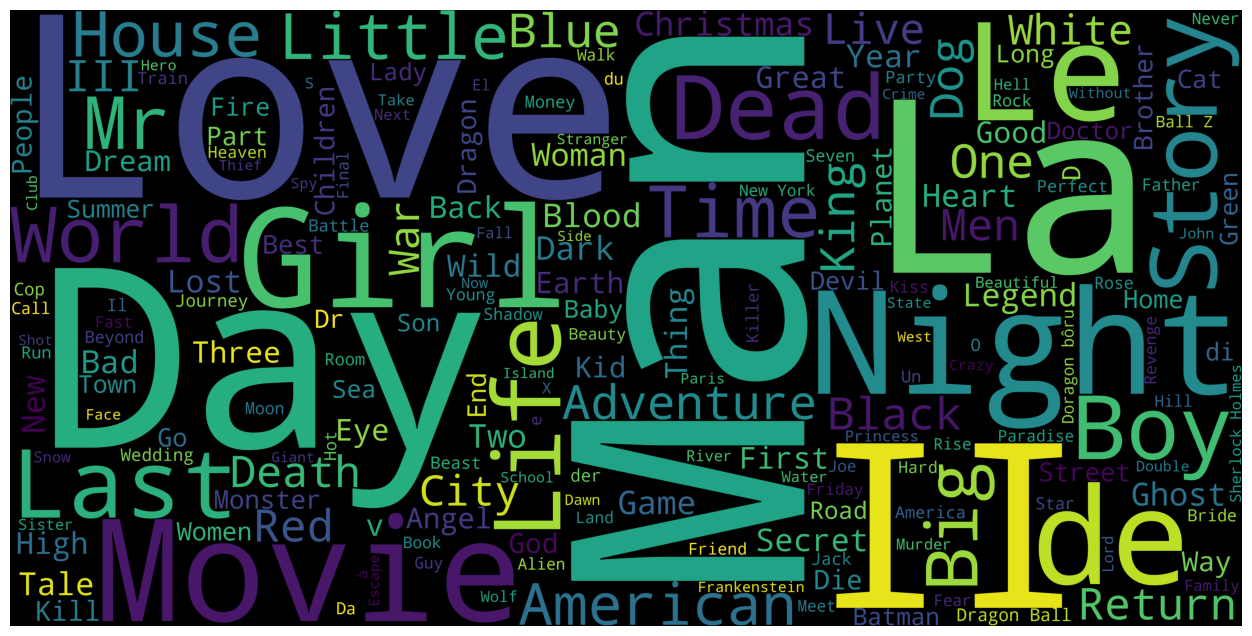

In [25]:
# Create a wordcloud of the movie titles
movies['title'] = movies['title'].fillna("").astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

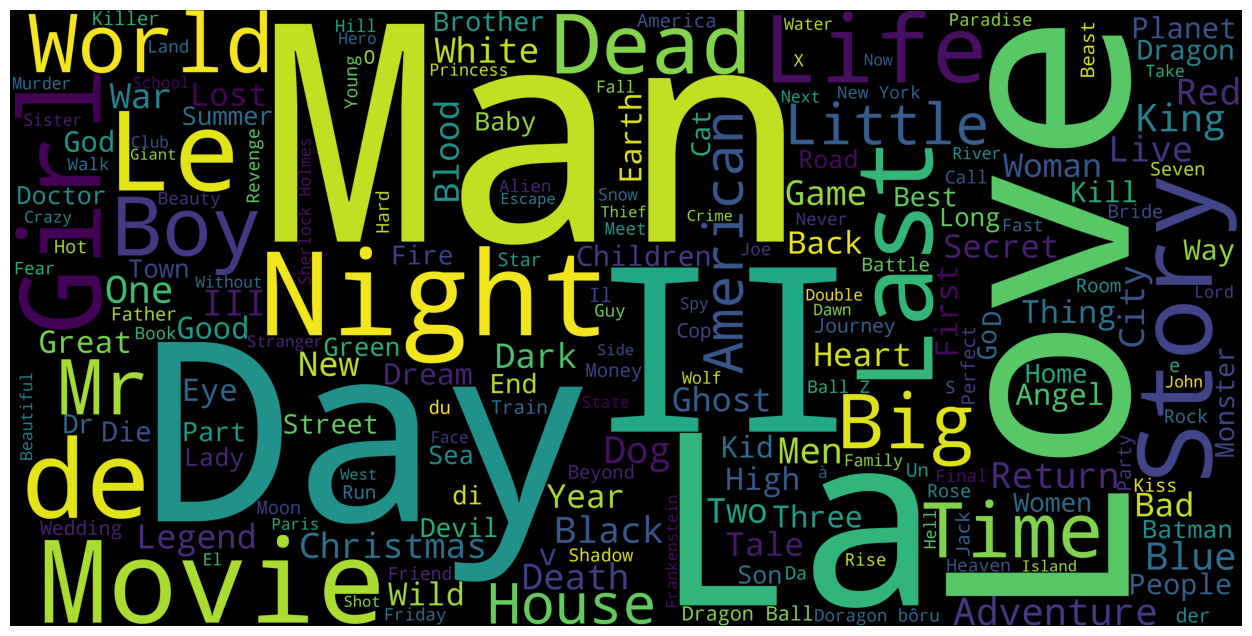

In [26]:
# Create a wordcloud of the tags titles
tag_corpus = ' '.join(tags['tag'])
tag_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(tag_wordcloud)
plt.axis('off')
plt.show()

In [27]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


In [30]:
average_ratings_per_user = ratings.groupby('userId').size().mean()
print("Average number of ratings per user: {:.2f}".format(average_ratings_per_user))

Average number of ratings per user: 165.30


In [31]:
ratings['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

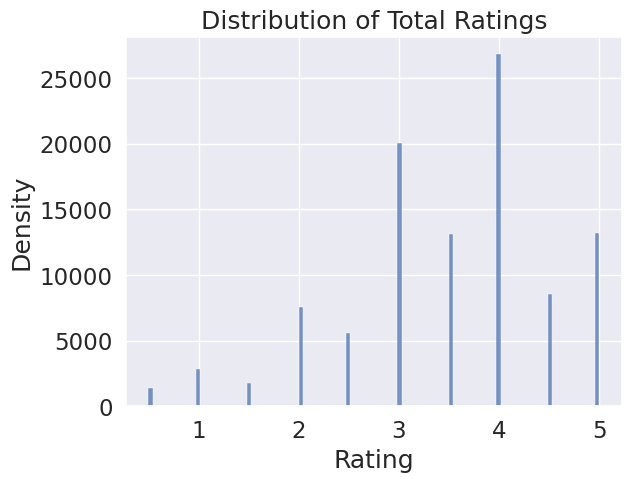

In [32]:
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline

# Display distribution of rating
sns.histplot(ratings['rating'].fillna(ratings['rating'].median()))

# Add labels and title
plt.xlabel('Rating')
plt.ylabel('Density')
plt.title('Distribution of Total Ratings')

plt.show()

## Data Cleaning and Processing

In [33]:
## for machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer

In [34]:
# Normalize the ratings between 0 and 1
max_rating = ratings['rating'].max()
min_rating = ratings['rating'].min()
print('Maximum Rating:', max_rating)
print('Minimum Rating:', min_rating)

ratings['rating'] = (ratings['rating'] - min_rating) / (max_rating - min_rating)
ratings.head()

Maximum Rating: 5.0
Minimum Rating: 0.5


,userId,movieId,rating
0,1,1,0.777778
1,1,3,0.777778
2,1,6,0.777778
3,1,47,1.000000
4,1,50,1.000000


In [35]:
movies = movies[movies['movieId'].isin(tags['movieId'])]
movies = movies.reset_index(drop=True)

ratings = ratings[ratings['movieId'].isin(tags['movieId'])]
ratings = ratings.reset_index(drop=True)

In [36]:
print(f"There are: {ratings['userId'].nunique()} unqiue users")
print(f"There are: {ratings['movieId'].nunique()} unqiue films in the ratings dataframe")
print(f"There are: {movies['movieId'].nunique()} unqiue films in the movies dataframe")
print(f"There are: {tags['movieId'].nunique()} unqiue films in the tags dataframe")


There are: 610 unqiue users
There are: 9275 unqiue films in the ratings dataframe
There are: 9275 unqiue films in the movies dataframe
There are: 9275 unqiue films in the tags dataframe


In [37]:
print(f'Ratings:\n',ratings.isna().sum())
print(f'\nMovies:\n',movies.isna().sum())
print(f'\nTags:\n',tags.isna().sum())

Ratings:
 userId     0
movieId    0
rating     0
dtype: int64

Movies:
 movieId    0
title      0
genres     0
dtype: int64

Tags:
 userId       0
movieId      0
tag          0
timestamp    0
dtype: int64


### Tag Data Cleaning

In [8]:
# Load the tags dataset
tags = pd.read_csv('../data/ml-latest/tags.csv')
print(tags.shape)
tags = tags.dropna()
tags.head()

(1108997, 4)


,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195


In [9]:
print("Unique Users:", tags['userId'].nunique())
print("\nUnique Tags:", tags['tag'].nunique())
print("\nNo. of NaN Values:\n", tags.isna().sum())

Unique Users: 19325

Unique Tags: 74714

No. of NaN Values:
 userId       0
movieId      0
tag          0
timestamp    0
dtype: int64


In [10]:
tags = tags[tags['movieId'].isin(movies['movieId'])]
tags = tags.reset_index(drop=True)
print(tags.shape)
tags.head()

(869911, 4)


,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195


In [11]:
print("Unique Users:", tags['userId'].nunique())
print("\nUnique Tags:", tags['tag'].nunique())
print("\nNo. of NaN Values:\n", tags.isna().sum())

Unique Users: 18448

Unique Tags: 54600

No. of NaN Values:
 userId       0
movieId      0
tag          0
timestamp    0
dtype: int64


In [13]:
#remove tags that occur less than 120 times from the tags dataframe
from collections import Counter

#get values for every tag and count the occurances
all_tags = tags['tag'].values
tag_counts = Counter(all_tags)

# Sort the tags by their frequencies in descending order 
sorted_tags = sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)

# Print the sorted tags(its a very long output)
# for tag, count in sorted_tags:
#     print(tag, count)

# Create a list of tags to remove (occurring less than 120 times)
no_of_tag_occurances = 120
tags_to_remove = [tag for tag, count in tag_counts.items() if count < no_of_tag_occurances]
print(len(tags_to_remove), "tags to be removed from dataframe")

#iterate through tags dataframe and find the index numbers of rows to be removed
index_to_remove = []
for num, tag in enumerate(tags['tag']):
    if tag in tags_to_remove:
        index_to_remove.append(num)
        
tags = tags.drop(index_to_remove)
tags = tags.reset_index(drop=True)
print(tags.shape)
tags.head()



In [14]:
print("Unique Tags:", tags['tag'].nunique())
print("\nNo. of NaN Values:\n", tags.isna().sum())

Unique Tags: 54600

No. of NaN Values:
 userId       0
movieId      0
tag          0
timestamp    0
dtype: int64


In [220]:
tags.to_csv('../data/ml-latest/tags_filtered_120.csv', index=False)

### Bring Data Together

In [38]:
#aggregate tags into list by movie id and merge with movies dataframe
tags_agg = tags.groupby('movieId')['tag'].agg(list)
movies_tag_df = pd.merge(movies, tags_agg, how='inner', on='movieId')

#eliminate duplicate tags in tag lists by turning into a set and then back into a list
movies_tag_df['tag'] = movies_tag_df['tag'].apply(lambda tags: list({tag for tag in tags}))

#display dataframe
print(movies_tag_df.shape)
movies_tag_df.head()

(9275, 4)


,movieId,title,genres,tag
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[friendship, pixar, feel-good, cartoon, Nation..."
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]","[based on a book, jungle, Kirsten Dunst, Fanta..."
2,3,Grumpier Old Men (1995),"[Comedy, Romance]","[duringcreditsstinger, CLV, sequel, comedy, go..."
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]","[chick flick, revenge, divorce, characters, CL..."
4,5,Father of the Bride Part II (1995),[Comedy],"[family, wedding, Fantasy, Comedy, pregnancy, ..."


In [39]:
longest_tag = max(movies_tag_df['tag'], key=len)
len(longest_tag)

184

In [40]:
# Extract the genre information
genres = movies_tag_df['genres'].values

# Perform one-hot encoding on the genre lists
mlb = MultiLabelBinarizer()
genre_features = mlb.fit_transform(genres)

# Retrieve the list of genre classes
genre_classes = mlb.classes_

# Create a new dataframe with the one-hot encoded genre features
genre_df = pd.DataFrame(genre_features, columns=genre_classes)
print(genre_df.shape)
genre_df.head()

(9275, 20)


,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


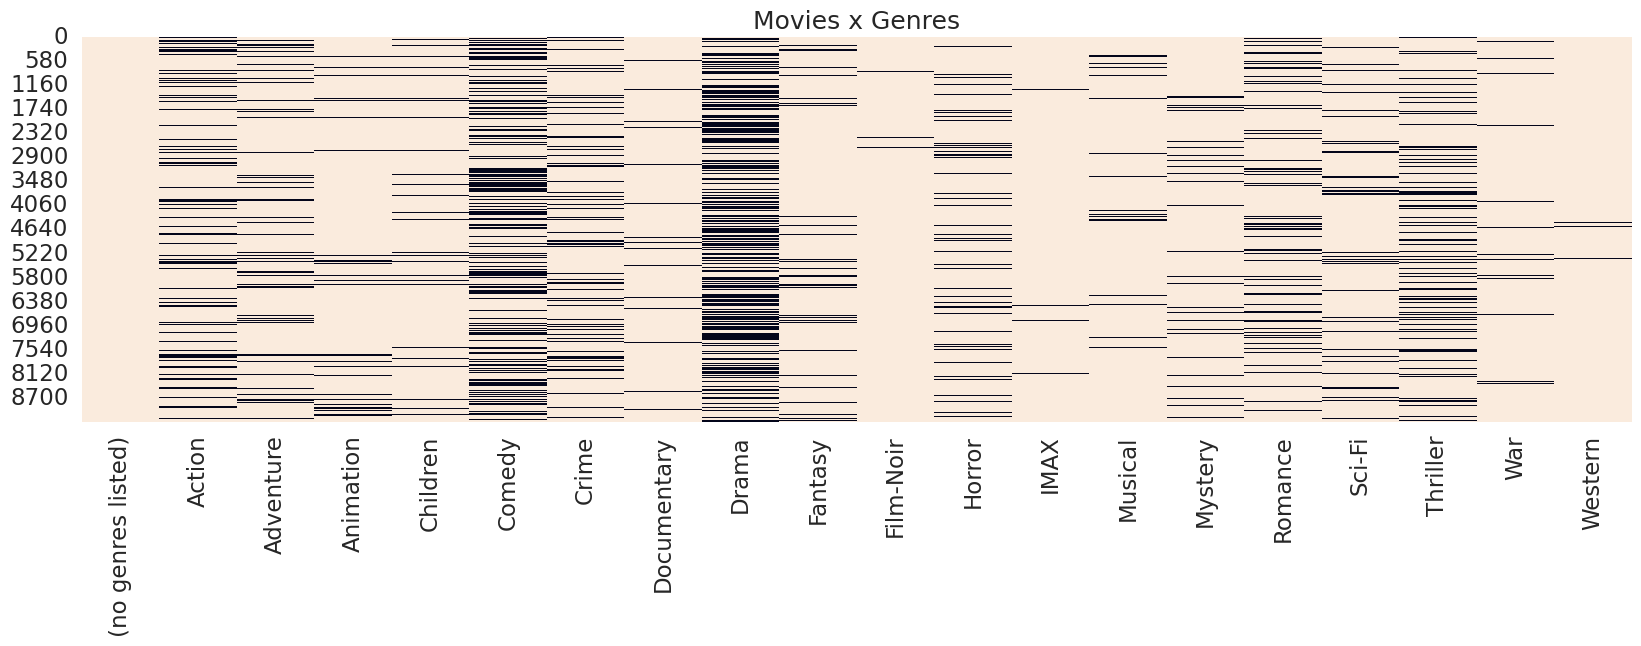

In [41]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(genre_df==0, vmin=0, vmax=1, cbar=False, ax=ax).set_title("Movies x Genres")
plt.show()

In [42]:
# Extract the tag information
tags = movies_tag_df['tag'].values

# Perform one-hot encoding on the tag lists
mlb = MultiLabelBinarizer()
tag_features = mlb.fit_transform(tags)

# Retrieve the list of tag classes
tag_classes = mlb.classes_

# Create a new dataframe with the one-hot encoded tag features
tag_df = pd.DataFrame(tag_features, columns=tag_classes)
print(tag_df.shape)
tag_df.head()

(9275, 1144)


,007,18th century,1920s,1930s,1950s,1960s,1970s,1980s,1990s,19th century,...,woman director,women,workplace,world war ii,wormhole,writer,writers,writing,zombie,zombies
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


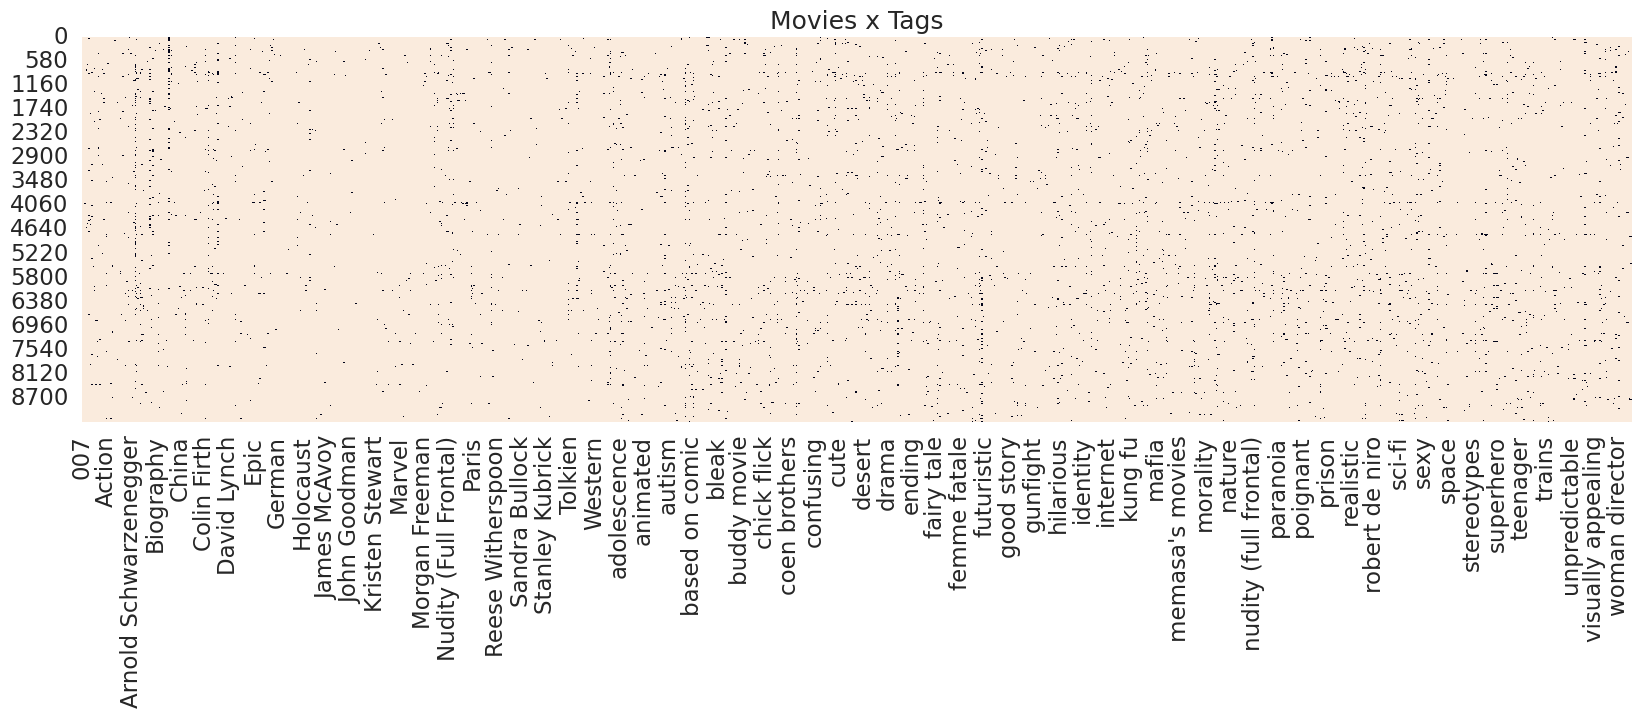

In [43]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(tag_df==0, vmin=0, vmax=1, cbar=False, ax=ax).set_title("Movies x Tags")
plt.show()

In [44]:
movies_features = pd.concat([movies_tag_df,genre_df,tag_df],axis=1)
print(movies_features.shape)
movies_features.head()

(9275, 1168)


,movieId,title,genres,tag,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,woman director,women,workplace,world war ii,wormhole,writer,writers,writing,zombie,zombies
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[friendship, pixar, feel-good, cartoon, Nation...",0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]","[based on a book, jungle, Kirsten Dunst, Fanta...",0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]","[duringcreditsstinger, CLV, sequel, comedy, go...",0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]","[chick flick, revenge, divorce, characters, CL...",0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),[Comedy],"[family, wedding, Fantasy, Comedy, pregnancy, ...",0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [45]:
movielens_df = pd.merge(ratings,movies_features,how='left', on = 'movieId')
movielens_df = movielens_df.drop(['title','genres','tag'],axis=1)
print(movielens_df.shape)
movielens_df.head()

(100165, 1167)


,userId,movieId,rating,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,woman director,women,workplace,world war ii,wormhole,writer,writers,writing,zombie,zombies
0,1,1,0.777778,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,3,0.777778,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,6,0.777778,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,47,1.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,50,1.000000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Hybrid Filtering with Users, Ratings, Genres and Tags

In [46]:
##for deep learning
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Concatenate, Embedding, Reshape, Dot
from tensorflow.keras.models import Model

2023-07-19 06:21:44.834034: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 06:21:44.946443: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [47]:
# Split the dataset into training and testing sets
train_data, test_data = train_test_split(movielens_df, test_size=0.2, random_state=42)

# Determine the maximum values of userId and movieId for embedding layer sizes
max_user_id = ratings['userId'].max()
max_movie_id = ratings['movieId'].max()

# Determine the number of genre and tag features
genre_len = len(genre_df.columns)
tag_len = len(tag_df.columns)

# Prepare the input data for the neural network
train_user_ids = train_data['userId'].values
train_movie_ids = train_data['movieId'].values
train_genres = train_data.iloc[:, 3:23].values
train_tags = train_data.iloc[:, 23:].values
train_ratings = train_data['rating'].values

test_user_ids = test_data['userId'].values
test_movie_ids = test_data['movieId'].values
test_genres = test_data.iloc[:, 3:23].values
test_tags = test_data.iloc[:, 23:].values
test_ratings = test_data['rating'].values

In [48]:
print(train_user_ids.shape)
print(train_movie_ids.shape)
print(train_genres.shape)
print(train_tags.shape)
print(train_ratings.shape)

(80132,)
(80132,)
(80132, 20)
(80132, 1144)
(80132,)


In [51]:
# Define the embedding sizes for users and movies
embedding_size = 50

############# COLLABORATIVE FILTERING ###############################################################################################
# Input Layers
user_input = Input(name='user_input', shape=(1,))
movie_input = Input(name='movie_input', shape=(1,))


# Matrix Factorization
## embed & reshape
cf_user_embedding = Embedding(name='cf_user_embedding', input_dim = max_user_id+1, output_dim = embedding_size)(user_input)
cf_user_reshape = Reshape(name = 'cf_user_reshape', target_shape=(embedding_size,))(cf_user_embedding)
cf_movie_embedding = Embedding(name='cf_movie_embedding', input_dim = max_movie_id+1, output_dim = embedding_size)(movie_input)
cf_movie_reshape = Reshape(name = 'cf_movie_reshape', target_shape=(embedding_size,))(cf_movie_embedding)

## Dot Product of users and movie embeddings
cf_user_movie_dot = Dot(name = 'cf_user_movie_dot', normalize=True, axes=1)([cf_user_reshape, cf_movie_reshape])

#Neural Network
## embed & reshape
nn_user_embedding = Embedding(name='nn_user_embedding', input_dim = max_user_id+1, output_dim = embedding_size)(user_input)
nn_user_reshape = Reshape(name = 'nn_user_reshape', target_shape=(embedding_size,))(nn_user_embedding)
nn_movie_embedding = Embedding(name='nn_movie_embedding', input_dim = max_movie_id+1, output_dim = embedding_size)(movie_input)
nn_movie_reshape = Reshape(name = 'nn_movie_reshape', target_shape=(embedding_size,))(nn_movie_embedding)

## concat & dense
nn_concat = Concatenate()([nn_user_reshape, nn_movie_reshape])
nn_dense = Dense(name="nn_dense", units=int(embedding_size/2), activation='relu')(nn_concat)



############# CONTENT BASED ###############################################################################################

#Genre Features
genre_input = Input(name="genre_input", shape=(genre_len,))
genre_features = Dense(name="genre_features", units=genre_len, activation='relu')(genre_input)

#TAG Features
tag_input = Input(name="tag_input", shape=(tag_len,))
tag_features = Dense(name="tag_features", units=tag_len, activation='relu')(tag_input)


############# OUTPUT ######################################################################################################


# Merge all
pred_ratings = Concatenate()([cf_user_movie_dot, nn_dense, genre_features, tag_features])
pred_ratings = Dense(name="pred_ratings", units=1, activation='linear')(pred_ratings)

# Compile
hybrid_model = Model(inputs=[user_input, movie_input,genre_input,tag_input], outputs=pred_ratings, name="hybrid_model")
hybrid_model.compile(loss='mse', optimizer='adam')

2023-07-19 06:22:41.601002: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [49]:
# hybrid_model.summary()

In [52]:
epochs = 10
batch_size = 128

# Train the model
hybrid_model.fit([train_user_ids, train_movie_ids, train_genres, train_tags], train_ratings, epochs = epochs, batch_size=batch_size, shuffle=True, validation_split=0.3)

Epoch 1/10
439/439 [==============================] - 32s 71ms/step - loss: 0.0548 - val_loss: 0.0393
Epoch 2/10
439/439 [==============================] - 31s 70ms/step - loss: 0.0364 - val_loss: 0.0387
Epoch 3/10
439/439 [==============================] - 30s 67ms/step - loss: 0.0203 - val_loss: 0.0410
Epoch 4/10
439/439 [==============================] - 30s 69ms/step - loss: 0.0110 - val_loss: 0.0418
Epoch 5/10
439/439 [==============================] - 31s 71ms/step - loss: 0.0073 - val_loss: 0.0437
Epoch 6/10
439/439 [==============================] - 29s 66ms/step - loss: 0.0054 - val_loss: 0.0448
Epoch 7/10
439/439 [==============================] - 29s 67ms/step - loss: 0.0043 - val_loss: 0.0459
Epoch 8/10
439/439 [==============================] - 29s 66ms/step - loss: 0.0038 - val_loss: 0.0463
Epoch 9/10
439/439 [==============================] - 29s 65ms/step - loss: 0.0034 - val_loss: 0.0471
Epoch 10/10
439/439 [==============================] - 29s 65ms/step - loss: 0.003

In [57]:
# import pickle

# # Save the model as a pickle file
# with open('hybrid_model.pkl', 'wb') as file:
#     pickle.dump(hybrid_model, file)

In [53]:
predictions = hybrid_model.predict([test_user_ids, test_movie_ids, test_genres, test_tags])
print("the highest rating the model predicted is:", np.max(predictions))
rmse = np.sqrt(mean_squared_error(test_ratings, predictions))
print('RMSE:', rmse)

627/627 [==============================] - 1s 2ms/step
the highest rating the model predicted is: 1.3248739
RMSE: 0.21919673806737014


10 epochs, batch size = 128 > RMSE 0.226 > highest rating: 1.29
10 epochs, batch size = 128 > RMSE 0.225 > highest rating: 1.0

20 epochs > RMSE 0.234 > highest rating: 1.33
20 epochs > RMSE 0.233 > highest rating: 1.30

100 epochs > 0.2202 > highest rating: 1.25
100 epochs > 0.2195 > highest rating: 1.00

In [54]:
predictions = np.clip(predictions, a_min=0, a_max=1.0)
print("the highest rating the model predicted is:", np.max(predictions))
rmse = np.sqrt(mean_squared_error(test_ratings, predictions))
print('RMSE:', rmse)

the highest rating the model predicted is: 1.0
RMSE: 0.21817026285188862


#### Time to Use Model for Recommendations

In [102]:
#get all the values of the movie Ids
movie_ids = movies_features['movieId'].values
movie_genres = genre_df.values
movie_tags = tag_df.values

# Choose the user for whom you want to make recommendations
test_user = 1

# Get predictions for all movies for the selected user
user_predictions = hybrid_model.predict([np.array([test_user] * len(movie_ids)), movie_ids, movie_genres, movie_tags])

# Unnormalize the ratings
user_predictions = user_predictions * (max_rating - min_rating) + min_rating

# Sort the predictions in descending order
# Exclude the movies that the user has already seen from the recommendations
top_movie_indices = user_predictions.argsort(axis=0)[::-1][:3]

#Clip ratings so ratings above 5.0 are 5 star ratings
user_predictions = np.clip(user_predictions, a_min=None, a_max=5.0)

# Retrieve the movie IDs of the top 3 movies
print("Top 3 Recommended Films for User", test_user)
for index in top_movie_indices:
    movie_title = movies.loc[index, 'title'].values
    rating = user_predictions[index]
    print("Movie:", movie_title[0], "| Predicted Rating:", rating[0][0])

290/290 [==============================] - 1s 2ms/step
Top 3 Recommended Films for User 1
Movie: Kingsman: The Secret Service (2015) | Predicted Rating: 5.0
Movie: Lives of Others, The (Das leben der Anderen) (2006) | Predicted Rating: 5.0
Movie: Human Nature (2001) | Predicted Rating: 5.0


In [103]:
# Choose the user for whom you want to make recommendations
test_user = 1

#create user_ratings dataframe
user_ratings = movielens_df[movielens_df['userId'] == test_user][['userId', 'movieId', 'rating']]
user_ratings['rating'] = user_ratings['rating'] * (max_rating - min_rating) + min_rating
user_ratings = pd.merge(user_ratings, movies,on = 'movieId', how='left')
user_films_viewed = user_ratings['movieId'].values

# Create an array of the user ID to match the shape of user_films_viewed
user_id_array = np.array([test_user] * len(user_films_viewed))

#create a array of all the genres & tags from the movies that the user watched
user_movie_features = movies_features[movies_features['movieId'].isin(user_ratings['movieId'])]
user_movie_genres = user_movie_features.iloc[:, 4:24].values
user_movie_tags = user_movie_features.iloc[:, 24:].values


# Get the model predictions for the user and movie IDs
user_predictions = hybrid_model.predict([user_id_array, user_films_viewed, user_movie_genres, user_movie_tags])
user_predictions = user_predictions * (max_rating - min_rating) + min_rating
user_predictions = np.clip(user_predictions, a_min=0, a_max=5.0)

#add a column for predicted rating to the data frame
user_ratings['predicted_rating'] = user_predictions
user_ratings.sort_values(by='rating',ascending=False)

8/8 [==============================] - 0s 2ms/step


,userId,movieId,rating,title,genres,predicted_rating
229,1,5060,5.0,M*A*S*H (a.k.a. MASH) (1970),"[Comedy, Drama, War]",4.072845
97,1,1517,5.0,Austin Powers: International Man of Mystery (1...,"[Action, Adventure, Comedy]",4.053545
90,1,1298,5.0,Pink Floyd: The Wall (1982),"[Drama, Musical]",5.000000
188,1,2948,5.0,From Russia with Love (1963),"[Action, Adventure, Thriller]",4.992697
187,1,2947,5.0,Goldfinger (1964),"[Action, Adventure, Thriller]",5.000000
...,...,...,...,...,...,...
168,1,2617,2.0,"Mummy, The (1999)","[Action, Adventure, Comedy, Fantasy, Horror, T...",4.057680
141,1,2253,2.0,Toys (1992),"[Comedy, Fantasy]",2.235517
146,1,2338,2.0,I Still Know What You Did Last Summer (1998),"[Horror, Mystery, Thriller]",3.013292
76,1,1219,2.0,Psycho (1960),"[Crime, Horror]",5.000000


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Concatenate, Flatten, Embedding
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer

2023-07-16 23:06:42.612815: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-16 23:06:42.736054: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
# Step 1: Load and preprocess the MovieLens dataset
movies = pd.read_csv("../data/ml-latest-small/movies.csv")
movies['genres'] = movies['genres'].str.split('|')
print(movies.shape)
movies.head()

(9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [ ]:
# Load the ratings dataset
ratings = pd.read_csv('../data/ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
print(f"There are: {ratings['userId'].nunique()} unqiue users")
print(f"There are: {ratings['movieId'].nunique()} unqiue films in the ratings dataframe")
print(f"There are: {movies['movieId'].nunique()} unqiue films in the movies dataframe")

There are: 610 unqiue users
There are: 9724 unqiue films in the ratings dataframe
There are: 9724 unqiue films in the movies dataframe


In [ ]:
movies = movies[movies['movieId'].isin(ratings['movieId'])]
movies = movies.reset_index(drop=True)
print(movies.shape)
movies.head()

(9724, 3)


,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [ ]:
# Load the tags dataset
tags = pd.read_csv('../data/ml-latest/tags_filtered.csv')
print(tags.shape)
tags.head()

(599255, 4)


,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,260,sci-fi,1442169410
2,14,260,space action,1442169421
3,14,318,imdb top 250,1442615195
4,14,318,justice,1442615192
